# Determining The Best Location For a High-End Gym In The City Of Helsinki,Finland , Using Clustering Approach 

###### 30/01/2022

![alt text](https://i.pinimg.com/originals/57/7d/c7/577dc7bc2fe5d9afbaa69cfd94e52a99.jpg)

## Overview

Starting a new business is a big decision to make as it requires in-depth planning and execution. This project attempts to map out, segment and explore the neighborhoods in the city of Helsinki, Finland using **K-means clustering**. The goal will be to help entrepreneurs and prospective business owners in this city decide optimum location(s) to start a new gym business.Namely, I made the assumption that the optimal location has the following neighborhood characteristics:

* High median income among inhabitants
* High population density
* High proportion of people between the ages of 18 to 39
* High concentration of public transportation stations
* Low concentration of pre-existing gyms


After gathering neighborhood data regarding each of the above, I used k-means clustering to segment the neighborhoods into four clusters. The decision to use k = 4 clusters was based on a comparison of inertia and silhouette scores across a range of k values.

Finally, I ranked the emerging clusters based on the new gym's estimated annual revenue in each cluster. The annual revenue estimated were computed using a formula based on a set of mathematical assumptions regarding each of the features' impact on revenue. According to the results, the neighborhood cluster consisting of **Sörnäinen** and **Punavuori** are the optimal new gym locations in Helsinki.


## 1.Introduction 

## 1.1 Business problem

Finnish people is famous for being one of the healthiest nations in the world [source](https://www.ghsindex.org/country/finland/)

A business client is planning to open new gym in the city of Helsinki,Finland.

As such, the objective of this project is to **determine the optimal Helsinki neighborhood(s) within which to open a new gym.**

To this end, I first segmented and clustered the neighborhoods in Helsinki based on a set of features that are linked to the new gym's likelihood of success. Subsequently, I computed the new gym's estimated annual revenue in each neighborhood cluster (using a set of business and mathematical assumptions), then generated a recommendation based on the results.

## 1.2 Assumptions: What makes any location "optimal"?

The gym that the client wants to open is high-end and luxurious with the best machines and facilities a gym can has. They are targeting the 18-39 age demographic, and the venue is expected to be particularly popular among students and workers.

Let's assume that based on preliminary research, the optimal location has the following characteristics:

* **High median income among inhabitants**
> Going to a gym, especially one that uses best machines and facilities, is a luxury activity. As such, the optimal location should accommodate inhabitants with high disposable income.

* **High population density**
> The higher the population density, the larger the customer base.

* **High proportion of people between the ages of 18 to 39**
> The new gym is predicted to be most popular among young people between the ages of 18 and 39.

* **High concentration of public transportation stations**
> Since the public transportation in Helsinki is one of the best in the world, people often use public transportation whenever they can. Hence, the optimal location should have a public transportation station nearby,so the gym is easy to reach.

* **Low concentration of pre-existing gym's**
> On the other hand, the ideal location should have a low concentration of pre-existing gyms to minimize competition.


## 1.3 Overview of Method
## Data Sources
Given the assumptions outlined above, I needed to collect two types of data for each Helsinki neighborhood: The first is population-related (i.e., population density, income, age), and the second is venue-related (i.e., concentration of pre-existing gyms and stations nearby).

Population-related data was obtained from the Tilastokeskus (or Statistics Finland) . Tilastokeskus is a Finnish governmental agency that annually publishes census and other types of data pertaining to Finland at the country, municipal, and neighborhood levels. From their website, I downloaded data regarding each Helsinki neighborhood's name and postal code, surface area, number of inhabitants (in 2021), median income (in 2021), and proportion of inhabitants according to age brackets (in 2021). This data can be downloaded in .csv or .xlsx formats via the following link: [Data published in 2022](https://pxnet2.stat.fi/PXWeb/pxweb/en/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2022/paavo_pxt_12f7.px/)

Venue-related data was obtained using the Foursquare API. Specifically, I used the Foursquare API V3 to generate a list of venues within 500m radius of each neighborhood's latitude-longitude coordinates in addition to the cateogry pertaining to each venue (e.g., gym, gym studio, asema). The latitude-longitude coordinates of each neighborhood were obtained using Geocoder, a geocoding library that converts postal codes into latitude-longitude coordinates. After obtaining the venue data from Foursquare, I counted the number of gyms and public transportation stations within a 500m radius of the neighborhood's central coordinates. I then used those counts as proxies for the availablity of public transportation and pre-existing gyms for the entire neighborhood.

## Data Wrangling
Data wrangling was conducted using  pandas.Specifically, pandas was used to load the population-related data and also to filter, relabel, and split columns where necessary. Second, some new variables were computed from existing columns (e.g., in the case of population density) and others, namely venue-related data from Foursquare, were gathered and appended to the dataframe.

## Visualization
Folium was used to generate a map of Helsinki with the individual neighborhoods and emerging clusters superimposed on top.

## Analytic Approach
K-means clustering was implemented using scikit-learn. Prior to clustering, the optimal number of clusters was determined via a comparison of inertia and silhouette scores across k values ranging from 2 to 11.

## Determining the Optimal Neighborhood Cluster
After clustering, I computed the means of each cluster's feature values. Next, an "annual revenue" value was estimated for each cluster (i.e., annual revenue of the new gym if it were to be opened within that cluster). Annual revenue values were estimated using a formula based on a set of mathematical assumptions regarding each feature's impact on the new gym's annual revenue. For example, I made the assumption that people aged 18-39 are four times more likely than others to visit the new gym. All of the assumptions used are discussed in depth in Section 3.4 Determining the Optimal Neighborhood Cluster. Finally, the neighborhood clusters were ranked according to annual revenue estimates, and a recommendation was made based on that ranking.

## Dependencies
Before gathering and exploring the data, I downloaded all dependencies required for the analysis:

In [106]:
# Main scientific library in Python
import numpy as np 

#Main data structure library in Python
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# Library to handle JSON files
import json 

# Library to handle requests
import requests 

# transform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Geocoder for getting the geographical coordinates of a given postal code
!pip install geocoder
import geocoder 

# Module for converting an address into latitude and longitude values
!pip install geopy
from geopy.geocoders import Nominatim 


# Module for mathematical functions
import math

# Import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Map-rendering library
!pip install folium
import folium 

print("imported libraries successfully!")

imported libraries successfully!


# 2.Data
# 2.1 Collecting Population-Related Data from Statistics Finland
### Downloading Data
Population-related data was downloaded from the Tilastokeskus (or Statistics Finland) website,[From this link](https://pxnet2.stat.fi/PXWeb/pxweb/en/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2022/paavo_pxt_12f7.px/) .

On the "Choose variables" page, I marked the following variables:

* Surface area
* Inhabitants, total, 2019(HE)
* 0-2 years, 2019 (HE)
* 3-6 years, 2019 (HE)
* 7-12 years, 2019 (HE)
* 13-15 years, 2019 (HE)
* 16-17 years, 2019 (HE)
* (cont'd)
* 75-79 years, 2019 (HE)
* 80-84 years, 2019 (HE)
* 85 years or over, 2019 (HE)
* Aged 18 or over, total, 2019 (KO)
* Median income of inhabitants, 2019 (HR)

And I chose the neighborhoods of Helsinki,after that I imported the excel file to pandas dataframe.

## Building the dataframe with pandas

In [107]:
raw=pd.read_excel(r"C:\Users\HP\Desktop\Mid Rest\HelsinkiData.xlsx")
raw.head()

,Neighborhood,Surface area,"Inhabitants, total, 2020 (HE)","0-2 years, 2020 (HE)","3-6 years, 2020 (HE)","7-12 years, 2020 (HE)","13-15 years, 2020 (HE)","16-17 years, 2020 (HE)","18-19 years, 2020 (HE)","20-24 years, 2020 (HE)","25-29 years, 2020 (HE)","30-34 years, 2020 (HE)","35-39 years, 2020 (HE)","40-44 years, 2020 (HE)","45-49 years, 2020 (HE)","50-54 years, 2020 (HE)","55-59 years, 2020 (HE)","60-64 years, 2020 (HE)","65-69 years, 2020 (HE)","70-74 years, 2020 (HE)","75-79 years, 2020 (HE)","80-84 years, 2020 (HE)","85 years or over, 2020 (HE)","Aged 18 or over, total, 2020 (KO)","Median income of inhabitants, 2020 (HR)"
0,00100 Helsinki keskusta - Etu-Töölö (Helsinki),2353278,18373,390,466,709,348,224,294,1587,2382,1872,1433,1278,1060,1109,1081,880,778,944,808,391,339,16236,29258
1,00120 Punavuori - Bulevardi (Helsinki),414010,7216,143,217,352,176,107,107,546,890,688,566,551,451,467,377,352,333,345,281,151,116,6221,29684
2,00130 Kaartinkaupunki (Helsinki),428960,1721,42,39,81,32,26,39,140,169,153,114,111,124,165,120,91,82,84,62,25,22,1501,31558
3,00140 Kaivopuisto - Ullanlinna (Helsinki),931841,7995,189,263,387,178,106,120,573,783,705,633,593,494,481,512,446,393,439,358,190,152,6872,31333
4,00150 Punavuori - Eira - Hernesaari (Helsinki),1367328,9440,220,261,414,136,87,137,808,1276,1005,803,752,570,539,510,461,395,398,352,153,163,8322,27997


# 2.2 Data manipulation using Pandas
The original table contained numerous variables that will not be used in the present analysis,for e.g. (people of ages outside the 18-39 year range). Thus, I created a new dataframe named "df" containing only the columns used in the present analysis

In [108]:
df=raw[["Neighborhood","Surface area","Inhabitants, total, 2020 (HE)","18-19 years, 2020 (HE)","20-24 years, 2020 (HE)","25-29 years, 2020 (HE)","30-34 years, 2020 (HE)","35-39 years, 2020 (HE)","Median income of inhabitants, 2020 (HR)"]].copy()

### I split the "Neighborhood" Column to two separate columns ,Neighborhood names and postal code
The "Neighborhood" column values consisted of the postal code followed by the neighborhood name followed by the city name (i.e., Helsinki) in parentheses. So I split the column values, creating a new column for the postal codes only.

In [109]:

df["Postal code"]=df["Neighborhood"].str[:5]
df["Neighborhood"]=df["Neighborhood"].str[5:]
df.head()


,Neighborhood,Surface area,"Inhabitants, total, 2020 (HE)","18-19 years, 2020 (HE)","20-24 years, 2020 (HE)","25-29 years, 2020 (HE)","30-34 years, 2020 (HE)","35-39 years, 2020 (HE)","Median income of inhabitants, 2020 (HR)",Postal code
0,Helsinki keskusta - Etu-Töölö (Helsinki),2353278,18373,294,1587,2382,1872,1433,29258,00100
1,Punavuori - Bulevardi (Helsinki),414010,7216,107,546,890,688,566,29684,00120
2,Kaartinkaupunki (Helsinki),428960,1721,39,140,169,153,114,31558,00130
3,Kaivopuisto - Ullanlinna (Helsinki),931841,7995,120,573,783,705,633,31333,00140
4,Punavuori - Eira - Hernesaari (Helsinki),1367328,9440,137,808,1276,1005,803,27997,00150


### Filtering and Relabeling Columns

 I changed the column labels to be more concise. 







In [110]:
df=df.rename(columns={'Surface area': 'area', 'Inhabitants, total, 2020 (HE)': 'population',"18-19 years, 2020 (HE)":"Age_18_19",
                  "20-24 years, 2020 (HE)":"Age_20_24","25-29 years, 2020 (HE)":"Age_25_29","30-34 years, 2020 (HE)":"Age_30_34",
                  "35-39 years, 2020 (HE)":"Age_35_39","Median income of inhabitants, 2020 (HR)":"Income_median"})

### Computing New Variables
Population Density and Percentage of People Aged 18-39 Next, I created two new variables: First, I computed "population density" by dividing the population of each neighborhood by its surface area. But prior to this, I converted the surface area values from square meters to square kilometers. Second, I computed the "percentage of peoiple aged 18-39" by summing the number of inhabitants in age groups 18-19, 20-24, 25-29,30-34 and 35-39 and then dividing that number by the neighborhood population.

In [111]:
# Converting neighborhood surface area from square meters to square kilometers
df['area'] = df ['area'] / 1000000

# Computing the population density of each neighborhood
df['Density'] = (df['population'] / df['area']).round(0).astype(int)

# Computing the percentage of people aged 18-39 in each neighborhood
df['Percent_18_39'] = (df['Age_18_19'] + df['Age_20_24'] + df['Age_25_29']+df['Age_30_34']+df['Age_35_39'])/df['population'] * 100

df.head()

,Neighborhood,area,population,Age_18_19,Age_20_24,Age_25_29,Age_30_34,Age_35_39,Income_median,Postal code,Density,Percent_18_39
0,Helsinki keskusta - Etu-Töölö (Helsinki),2.353278,18373,294,1587,2382,1872,1433,29258,00100,7807,41.190878
1,Punavuori - Bulevardi (Helsinki),0.414010,7216,107,546,890,688,566,29684,00120,17430,38.761086
2,Kaartinkaupunki (Helsinki),0.428960,1721,39,140,169,153,114,31558,00130,4012,35.735038
3,Kaivopuisto - Ullanlinna (Helsinki),0.931841,7995,120,573,783,705,633,31333,00140,8580,35.196998
4,Punavuori - Eira - Hernesaari (Helsinki),1.367328,9440,137,808,1276,1005,803,27997,00150,6904,42.680085


### Comparing the Total Area and Population of Helsinki with an official reference

To double check,I quickly confirmed the total area, population, and population density of Helsinki according to the dataset.

In particular, I cross-referenced them with the City of Helsinki's 2020 estimates [Link](https://www.hel.fi/hel2/tietokeskus/julkaisut/pdf/20_06_18_HKI_taskutilasto2020_eng.pdf):

* A total population of 653,835
* Total land area of 217 sq km
* Population density of 2,993 per sq km

And the overall numbers were very close to City of Helsinki's 2020 estimates.




In [112]:
print('Total population:', "{:,}".format(df['population'].sum()))
print('Surface area:', df['area'].sum().round(2), 'sq km')
print('Population density:', "{:,}".format(round(df['population'].sum()/df['area'].sum())), 'people per sq km.')

Total population: 645,918
Surface area: 213.44 sq km
Population density: 3,026 people per sq km.


### 2.3 Obtaining Latitude and Longitude Coordinates using Geocoder
After collecting and cleaning the population-related data, the next step was to gather venue-related data using the Foursquare API. But in order to do so, I first needed to obtain the latitude-longitude coordinates of each neighborhood. Thus, I used geocoder, which converts postal codes into latitude-longitude coordinates.

Using Geocoder to Obtain the Latitude and Longitude Coordinates of Each Neighborhood

In [113]:
GeocoderAPI_key="AIza####SyB###################3"


In [114]:
# First, create 'get_geocoder' function:
def get_geocoder(PostalCode):
    # Initialize variable to None
    lat_lng_coords = None
    # Loop until all coordinates are obtained
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Helsinki, Finland'.format(PostalCode), key = GeocoderAPI_key)
      lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude, longitude

# Second, append latitude and longitude columns to the dataframe
df['Latitude'], df['Longitude'] = zip(*df['Postal code'].apply(get_geocoder))
df.head()

,Neighborhood,area,population,Age_18_19,Age_20_24,Age_25_29,Age_30_34,Age_35_39,Income_median,Postal code,Density,Percent_18_39,Latitude,Longitude
0,Helsinki keskusta - Etu-Töölö (Helsinki),2.353278,18373,294,1587,2382,1872,1433,29258,00100,7807,41.190878,60.172667,24.932009
1,Punavuori - Bulevardi (Helsinki),0.414010,7216,107,546,890,688,566,29684,00120,17430,38.761086,60.162903,24.942100
2,Kaartinkaupunki (Helsinki),0.428960,1721,39,140,169,153,114,31558,00130,4012,35.735038,60.165355,24.949161
3,Kaivopuisto - Ullanlinna (Helsinki),0.931841,7995,120,573,783,705,633,31333,00140,8580,35.196998,60.157442,24.953881
4,Punavuori - Eira - Hernesaari (Helsinki),1.367328,9440,137,808,1276,1005,803,27997,00150,6904,42.680085,60.151148,24.923553


### Dropping Columns
I then dropped the columns that were no longer needed, namely those regarding surface area, population, age variables (i.e., the original ones), and postal codes, and saved the resulting dataframe with the name "df_short."

In [115]:
df_short = df.copy()
df_short.drop(['area','population','Age_18_19','Age_20_24','Age_25_29','Age_30_34','Age_35_39','Postal code'], axis=1, inplace=True)
df_short.head()

,Neighborhood,Income_median,Density,Percent_18_39,Latitude,Longitude
0,Helsinki keskusta - Etu-Töölö (Helsinki),29258,7807,41.190878,60.172667,24.932009
1,Punavuori - Bulevardi (Helsinki),29684,17430,38.761086,60.162903,24.942100
2,Kaartinkaupunki (Helsinki),31558,4012,35.735038,60.165355,24.949161
3,Kaivopuisto - Ullanlinna (Helsinki),31333,8580,35.196998,60.157442,24.953881
4,Punavuori - Eira - Hernesaari (Helsinki),27997,6904,42.680085,60.151148,24.923553


## 2.4 Mapping Helsinki Neighborhoods with Folium
After obtaining the latitude and longitude coordinates, I created a map of Helsinki with each of the neighborhoods superimposed on top:

### Obtaining the Latitude-Longitude Coordinates of Helsinki

In [116]:
# Using the geopy library to get the lat-long coordinates of Helsinki
address = 'Helsinki, Finland'

geolocator = Nominatim(user_agent="helsinki_explorer")
location = geolocator.geocode(address)
helsinki_latitude = location.latitude
helsinki_longitude = location.longitude
print('The geograpical coordinate of Helsinki is {}, {}.'.format(helsinki_latitude, helsinki_longitude))

The geograpical coordinate of Helsinki is 60.1674881, 24.9427473.


### Map of Helsinki with Each of the Neighborhoods Superimposed on Top


In [117]:
# Creating a map of Helsinki using the foregoing lat-long coordinates
map_helsinki = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11)

# Adding markers to the map
for lat, lng, neighborhood in zip(df_short['Latitude'], df_short['Longitude'], df_short['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_helsinki)  
    
map_helsinki

## 2.5 Collecting Venue-Related Data with Foursquare API
I then proceeded to collect venue-related data using the Foursquare API. Again, the key variables of interest were the (a) concentration of public transportation stations and (b) concentration of gyns venues in each neighborhood.

### Defining Foursquare API Credentials and Version

In [118]:
CLIENT_ID = "LPEGD##############"

CLIENT_SECRET = "M######B"
VERSION = '20220129' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value
df.head()

,Neighborhood,area,population,Age_18_19,Age_20_24,Age_25_29,Age_30_34,Age_35_39,Income_median,Postal code,Density,Percent_18_39,Latitude,Longitude
0,Helsinki keskusta - Etu-Töölö (Helsinki),2.353278,18373,294,1587,2382,1872,1433,29258,00100,7807,41.190878,60.172667,24.932009
1,Punavuori - Bulevardi (Helsinki),0.414010,7216,107,546,890,688,566,29684,00120,17430,38.761086,60.162903,24.942100
2,Kaartinkaupunki (Helsinki),0.428960,1721,39,140,169,153,114,31558,00130,4012,35.735038,60.165355,24.949161
3,Kaivopuisto - Ullanlinna (Helsinki),0.931841,7995,120,573,783,705,633,31333,00140,8580,35.196998,60.157442,24.953881
4,Punavuori - Eira - Hernesaari (Helsinki),1.367328,9440,137,808,1276,1005,803,27997,00150,6904,42.680085,60.151148,24.923553


## Defining a Function to Yield All Venues Present in Each Neighborhood Within a 500 Meter Radius

Using version 3 of Foursquare api I built this function,the result will be dataframe with the columns we need.


In [119]:

  def getNearbyVenues(names, latitudes, longitudes, radius=500,limit=5):

    URL= "https://api.foursquare.com/v3/places/nearby?ll={},{}&radius={}&limit={}"
    headers = {
        "Accept": "application/json",
        "Authorization": "#################Jo="
    }

    df_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = URL.format(lat, lng, radius, LIMIT)
        results = requests.request("GET", url, headers=headers).json()
        
        for each_result in results['results']: # filter the result based on JSON identification
            result={}
            result['Neighborhood']=name
            result['Neighborhood Latitude']=lat
            result['Neighborhood Longitude']=lng
            result['Venue']=each_result['name']
            result['Venue Latitude']=each_result['geocodes']['main']['latitude']
            result['Venue Longitude']=each_result['geocodes']['main']['longitude']
            result['Venue Category']=[each_name['name'] for each_name in each_result['categories']]
            df_list.append(result.copy())
    return pd.DataFrame(df_list)

## Running the Function and Saving the Results to a New Dataframe Called df_venues


In [120]:

# Saving to new dataframe
df_venues = getNearbyVenues(names=df['Neighborhood'],
                            latitudes=df['Latitude'],
                            longitudes=df['Longitude']
                            )

# Show the first 5 observations
df_venues.head(5)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Eduskuntatalo / Riksdagshuset,60.172500,24.933333,[Capitol Building]
1,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Eduskunnan kirjasto,60.172629,24.931362,[Library]
2,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Sauna of the parliament building (Eduskunnan s...,60.173081,24.932549,[Health and Beauty Service]
3,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Pikkuparlamentti,60.171408,24.934483,[Capitol Building]
4,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Kuntosali,60.172848,24.932146,[Gym and Studio]


### Size of the Resulting Dataframe


In [121]:
df_venues.shape

(4033, 7)

### Changing the type of "Venue Category" column to string 

In [122]:
df_venues["Venue Category"]=df_venues["Venue Category"].astype(str).str.replace('\[|\]|\'', '',regex=True)

### Counting the Number of Unique Venue Categories Curated from Venues Returned


In [123]:
df_venues["Venue Category"].nunique()

501

### Counting the Number of Venues in Each Neighborhood


In [124]:
df_venues.groupby('Neighborhood').count().sort_values(by ='Venue', ascending=False)[['Venue']]


,Venue
Neighborhood,
Pajamäki (Helsinki),50
Myllypuro (Helsinki),50
Kamppi - Ruoholahti (Helsinki),50
Kruunuvuorenranta (Helsinki),50
Vattuniemi (Helsinki),50
Kaartinkaupunki (Helsinki),50
Jätkäsaari (Helsinki),50
Keski-Töölö (Helsinki),50
Keski-Herttoniemi - Roihupelto (Helsinki),50


### Encoding  of Gyms and Public transportation stations .
After obtaining a list of all venues and venue categories, the next step was to count the number of Gyms and Public transportation stations in each neighborhood.

So first, I created two new columns: "Venue_gym" and "asema" ,asema is the Finnish word of station. The purpose of this was to encode based on whether they were categorized by Foursquare as a gym type or  Public transportation stations: gym would receive "1" in the Venue_gym column and "0" if otherwise, and vice versa for Public transportation stations in the "asema" column.

To determine whether a venue falls into the Gyms or Public transportation stations, I had look at the result foursquare table. According to the result table, all gyms  contain the string "gym" in its "Venue category" field, whereas all Public transportation stations contain the string "bus" in "Venue category" and "asema" in "Venue" field.



In [125]:
df_venues['Venue_gym'] = df_venues['Venue Category'].str.contains('gym',case=False).astype(int)
df_venues['asema'] = df_venues['Venue'].str.contains('asema',case=False).astype(int)+df_venues['Venue Category'].str.contains('bus',case=False).astype(int)

# Show the first 20 observations
df_venues.head(20)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue_gym,asema
0,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Eduskuntatalo / Riksdagshuset,60.172500,24.933333,Capitol Building,0,0
1,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Eduskunnan kirjasto,60.172629,24.931362,Library,0,0
2,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Sauna of the parliament building (Eduskunnan s...,60.173081,24.932549,Health and Beauty Service,0,0
3,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Pikkuparlamentti,60.171408,24.934483,Capitol Building,0,0
4,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Kuntosali,60.172848,24.932146,Gym and Studio,1,0
5,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Taidehalli,60.172127,24.931014,Art Gallery,0,0
6,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Natural History Museum (Luonnontieteellinen mu...,60.171350,24.931549,Science Museum,0,0
7,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Finnjävel,60.171875,24.931618,Scandinavian Restaurant,0,0
8,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Luomus,60.171287,24.930957,History Museum,0,0
9,Helsinki keskusta - Etu-Töölö (Helsinki),60.172667,24.932009,Eduskuntaravintola,60.172127,24.933317,Restaurant,0,0


### Summing the Number of Gyms and Public transportation stations in Each Neighborhood
Next, I summed the number of Gyms and Public transportation stations in each neighborhood.



In [126]:

df_venues_freq = df_venues.groupby('Neighborhood').sum()[['Venue_gym','asema']].reset_index()
df_venues_freq.head(20)

,Neighborhood,Venue_gym,asema
0,Alppila - Vallila (Helsinki),1,4
1,Aurinkolahti (Helsinki),0,0
2,Etelä-Haaga (Helsinki),0,7
3,Etelä-Vuosaari (Helsinki),0,3
4,Gunillanmäki - Hevossalmi (Helsinki),1,3
5,Helsinki keskusta - Etu-Töölö (Helsinki),1,4
6,Helsinki postikeskus (Helsinki),1,2
7,Herttoniemenranta (Helsinki),1,6
8,Itä- ja Keski-Pasila (Helsinki),0,5
9,Itä-Pakila (Helsinki),1,8


### Merging Population- And Venue-Related Data
I then merged the population-.and venue-related dataframes, and saved the resulting dataframe with the name "df2."

In [127]:
df2=df_short.merge(df_venues_freq, how = 'inner', on = 'Neighborhood')
df2.head()

,Neighborhood,Income_median,Density,Percent_18_39,Latitude,Longitude,Venue_gym,asema
0,Helsinki keskusta - Etu-Töölö (Helsinki),29258,7807,41.190878,60.172667,24.932009,1,4
1,Punavuori - Bulevardi (Helsinki),29684,17430,38.761086,60.162903,24.942100,0,1
2,Kaartinkaupunki (Helsinki),31558,4012,35.735038,60.165355,24.949161,0,2
3,Kaivopuisto - Ullanlinna (Helsinki),31333,8580,35.196998,60.157442,24.953881,1,1
4,Punavuori - Eira - Hernesaari (Helsinki),27997,6904,42.680085,60.151148,24.923553,0,2


### Removing Neighborhood with Zero Population
I noticed that there was an observation with zero inhabitants. I removed this single outlier, as a neighborhood with zero inhabitants would not be considered as a good spot to open a new gym.

In [128]:
# Removing observation where population density = 0
df2 = df2[df2.Density != 0].reset_index(drop = True)
df2.head()

,Neighborhood,Income_median,Density,Percent_18_39,Latitude,Longitude,Venue_gym,asema
0,Helsinki keskusta - Etu-Töölö (Helsinki),29258,7807,41.190878,60.172667,24.932009,1,4
1,Punavuori - Bulevardi (Helsinki),29684,17430,38.761086,60.162903,24.942100,0,1
2,Kaartinkaupunki (Helsinki),31558,4012,35.735038,60.165355,24.949161,0,2
3,Kaivopuisto - Ullanlinna (Helsinki),31333,8580,35.196998,60.157442,24.953881,1,1
4,Punavuori - Eira - Hernesaari (Helsinki),27997,6904,42.680085,60.151148,24.923553,0,2


### Descriptive Statistics
At this point, the data was ready for clustering analysis. But prior to clustering, I inspected descriptive statistics.

In [129]:
df2.describe()


,Income_median,Density,Percent_18_39,Latitude,Longitude,Venue_gym,asema
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,26576.650602,4461.771084,33.788297,60.208058,24.975392,0.831325,4.024096
std,3416.480793,3472.936602,8.850638,0.033531,0.081380,0.985496,2.527777
min,20429.000000,56.000000,17.669740,60.144209,24.843902,0.000000,0.000000
25%,23934.500000,2250.000000,28.016371,60.184026,24.913722,0.000000,2.000000
50%,26208.000000,3645.000000,32.908605,60.208732,24.961595,1.000000,4.000000
75%,28756.500000,5410.500000,39.716444,60.232790,25.032581,1.000000,6.000000
max,34743.000000,20476.000000,60.973577,60.277193,25.185683,5.000000,10.000000


So on average, the 83 neighborhoods have a median annual income of €26576.650602, population density of 4461.771084 per sq km, and people aged 18-39 comprising 33.7% of the inhabitants. Furthermore, on average, there is around 1 gym and 5 public transportation stations per 500m radius area.

# 3. Analysis and Results
### 3.1 Determining the Optimal Number of Clusters with Inertia and Silhouette Scores
I used k-means clustering to cluster the neighborhoods based on the following five features: (a) Density, (b) Median income, (c) Percentage of people aged 18-39, (d) Concentration of gyms, and (e) Concentration of public transportation.

To do this, I first determined the optimal number of clusters by comparing the inertia and silhouette scores across k values ranging from 2 to 11 (for this analysis, a k value exceeding 11 was deemed too large to be practical).

### Creating Dataframe of Features Only
I created a new dataframe containing only the 5 features of interest.

In [130]:
df_features = df2.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)
df_features.head()

C:\Users\HP\AppData\Local\Temp/ipykernel_1056/8350118.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_features = df2.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)


,Income_median,Density,Percent_18_39,Venue_gym,asema
0,29258,7807,41.190878,1,4
1,29684,17430,38.761086,0,1
2,31558,4012,35.735038,0,2
3,31333,8580,35.196998,1,1
4,27997,6904,42.680085,0,2


Next, I plotted the inertia and silhouette using matplotlib



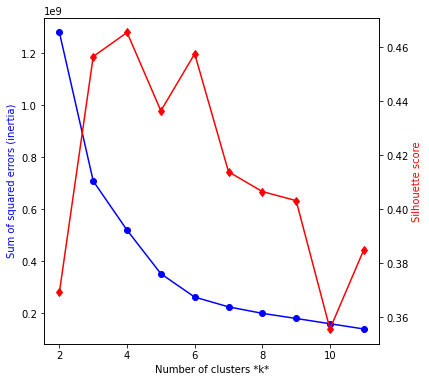

In [131]:
# Creating empty lists
inertia = []
silhouette = []
K = list(range(2, 12))

# Appending relevent scores to the lists
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(df_features)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(df_features, km.labels_))

# Creating the plot
fig, ax1 = plt.subplots(figsize=(6, 6))

ax2 = ax1.twinx()
ax1.plot(K, inertia, 'bo-')
ax2.plot(K, silhouette, 'rd-')

ax1.set_xlabel(r'Number of clusters *k*')
ax1.set_ylabel('Sum of squared errors (inertia)', color='b')
ax2.set_ylabel('Silhouette score', color='r')

plt.show()

Based on the plot, I determined that k = 4 is the optimal number of clusters. To elaborate, k = 4 is the value that maximizes the silhouette score and at which the inertia plot begins to "flatten." 
### 3.2 K-Means Clustering
Next, I ran k-means clustering using sci-kit learn

In [132]:
# Setting number of clusters
kclusters = 4

# Running k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_features)

# Checking the cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 0, 3, 3, 0, 1, 3, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 3, 0, 3, 3, 3, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

### Adding Cluster Labels to the Dataframe


In [133]:
# Adding cluster labels
df2.insert(0, 'Cluster Labels', kmeans.labels_)

df2.head()

,Cluster Labels,Neighborhood,Income_median,Density,Percent_18_39,Latitude,Longitude,Venue_gym,asema
0,3,Helsinki keskusta - Etu-Töölö (Helsinki),29258,7807,41.190878,60.172667,24.932009,1,4
1,2,Punavuori - Bulevardi (Helsinki),29684,17430,38.761086,60.162903,24.942100,0,1
2,1,Kaartinkaupunki (Helsinki),31558,4012,35.735038,60.165355,24.949161,0,2
3,3,Kaivopuisto - Ullanlinna (Helsinki),31333,8580,35.196998,60.157442,24.953881,1,1
4,3,Punavuori - Eira - Hernesaari (Helsinki),27997,6904,42.680085,60.151148,24.923553,0,2


### Adding Cluster Labels to the Dataframe


In [134]:
# Creating a map of Helsinki
map_clusters = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11)

# Setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.8, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood'], df2['Cluster Labels']):
    label = folium.Popup(' ' + str(poi) + ': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 3.4 Determining the Optimal Neighborhood Cluster
The final step of the analysis was to determine the optimal neighborhood(s) based on the average feature values of each cluster.

### Average Feature Values for Each Cluster
I created a new dataframe displaying the mean feature values for each neighborhood cluster.

In [135]:
cluster_means = df2.drop(columns=['Latitude', 'Longitude']).groupby('Cluster Labels').mean()
cluster_means = cluster_means.reset_index()
cluster_means

,Cluster Labels,Income_median,Density,Percent_18_39,Venue_gym,asema
0,0,24397.739130,3571.673913,34.088159,0.934783,4.456522
1,1,30780.100000,1962.100000,25.786190,0.550000,4.150000
2,2,26501.500000,18953.000000,49.867332,0.500000,1.500000
3,3,27664.066667,8592.133333,41.394328,0.933333,2.866667


## Mathematical Assumptions Linking each Feature to the Estimated Annual Revenue of the New gym
In this analysis, I operationalized "optimal location" as the location that maximizes the estimated annual revenue of the new gym.

To estimate the new gym's annual revenue in each neighborhood cluster, I used the following assumptions regarding how each feature impacts annual revenue. Let's assume that all of these assumptions have been pre-determined by the hypothetical client based on prior research.

**1. The size of the gym's target market is more-or-less equal to the number of neighborhood inhabitants per sq km, or population density.**

Example: If a neighborhood has 1000 people per sq km, then 1000 is the maximum number of people that the gym can reach per year.

**2. If there are NO pre-existing gyms nearby, the new gym will attract 20% of inhabitants aged 18-39 versus 5% of all other inhabitants.**

Example: Assume that a neighborhood has a population density of 1000 and that 50% of them is aged 18-39. The new gym will attract 100 customers aged 18-39 (i.e., 20% of its target age base of 500) and 25 customers of all other ages (i.e., 5% of its non-target age base of 500), assuming there are no gyms nearby.

**3. If there ARE public transportation station nearby, the probability of attracting customers, regardless of age, is enhanced by "log(10 + 'concentration of public transportation stations')" times.**

In other words, the number of customers attracted rises logarithmically based on the concentration of public transportation station.

Example: In a neighborhood with 0 public transportation station (and 0 gyms), the gym has a 20% chance of attracting a person aged 18-39. In contrast, in a neighborhood with 1 public transportation station per 500m radius area, the probability rises to 20.8% (i.e., 20% times log(10 + 1) ). If the concentration of public transportation station is 10, 50, or 100, then that probability rises to 26.0%, 35.6%, and 40.8%, respectively.

**4. If there ARE pre-existing gym nearby, the probability of attracting customers, regardless of age, is divided by "1 + 'concentration of gyms' "**

In other words, the number of customers attracted falls proportionately based on the concentration of pre-existing gyms

Example: In a neighborhood with 0 gym (and 0 public transportation station), the gym has a 20% probability of attracting a person aged 18-39. In contrast, in a neighborhood with 1 pre-existing gym per 500m radius area, the probability reduced to 10%.

**5. Collectively, the new gym's visitors spend 2% of their annual income at the gym per year**

Example: Assume that the total number of unique visitors in a year is 100. Additionally, the median income of those visitors is €50,000. The estimated annual revenue of the new gym, then, is €100,000 (i.e., 2% of 100 times €50,000).

###  Defining a Function to Estimate Annual Revenue
Based on the assumptions outlined above, I created a function that generates the following new columns:

* Target age base: The number of inhabitants aged 18-39 that the gym can reach (i.e., density times the proportion of those aged 18-39)

* Non-target age base: The number of inhabitants NOT aged 18-39 that the gym can reach

* Target age visitors (baseline): The number of inhabitants aged 18-39 that the gym will attract, without adjusting for nearby venues
* Non-target age visitors (baseline): The number of inhabitants NOT aged 18-39 that the gym will attract, without adjusting for nearby venues
* Target age visitors (adjusted): The number of inhabitants aged 18-39 that the gym will attract, after adjusting for nearby venues
* Non-target age visitors (adjusted): The number of inhabitants NOT aged 18-39 that the gym will attract, after adjusting for nearby venues
* Total visitors: The total number of unique visitors the gym will attract in a given year
* Annual revenue: The gym's estimated annual revenue

In [136]:
def revenue(x):
    x['Target age base'] = (x['Density'] * x['Percent_18_39'] / 100).astype(int)
    x['Non-target age base'] = (x['Density'] - x['Target age base']).astype(int)
    x['Target age visitors (baseline)'] = (x['Target age base'] * 0.2).astype(int)
    x['Non-target age visitors (baseline)'] = (x['Non-target age base'] * 0.05).astype(int)
    x['Target age visitors (adjusted)'] = (x['Target age visitors (baseline)'] * np.log10(10 + x['asema']) / (1 + x['Venue_gym'])).astype(int)
    x['Non-target age visitors (adjusted)'] = (x['Non-target age visitors (baseline)'] * np.log10(10 + x['asema']) / (1 + x['Venue_gym'])).astype(int)
    x['Total visitors'] = (x['Target age visitors (adjusted)'] + x['Non-target age visitors (adjusted)']).astype(int)
    x['Annual revenue'] = (x['Total visitors'] * x['Income_median'] * 0.02).astype(int)
    
    x.drop(['Income_median','Density','Percent_18_39','Venue_gym','asema'], axis=1, inplace=True)
    return

### Running the Function to Estimate Annual Revenues for Each Cluster


In [137]:
cluster_revenues = cluster_means.copy()
cluster_revenues
revenue(cluster_revenues)
cluster_revenues

,Cluster Labels,Target age base,Non-target age base,Target age visitors (baseline),Non-target age visitors (baseline),Target age visitors (adjusted),Non-target age visitors (adjusted),Total visitors,Annual revenue
0,0,1217,2354,243,117,145,70,215,104910
1,1,505,1457,101,72,74,53,127,78181
2,2,9451,9502,1890,475,1336,335,1671,885680
3,3,3556,5036,711,251,408,144,552,305411


So Cluster 2 has the highest estimated annual revenue of €885,680

### 3.5 Visual Comparison of Neighborhood Clusters
Next, I visually compared the neighborhood clusters based on feature values (e.g., population density, median income) in addition to other, computed variables such as estimated annual revenue.

In [138]:
# Merging dataframes
cluster_results = cluster_means.merge(cluster_revenues, how = 'inner', on = 'Cluster Labels')
cluster_results

,Cluster Labels,Income_median,Density,Percent_18_39,Venue_gym,asema,Target age base,Non-target age base,Target age visitors (baseline),Non-target age visitors (baseline),Target age visitors (adjusted),Non-target age visitors (adjusted),Total visitors,Annual revenue
0,0,24397.739130,3571.673913,34.088159,0.934783,4.456522,1217,2354,243,117,145,70,215,104910
1,1,30780.100000,1962.100000,25.786190,0.550000,4.150000,505,1457,101,72,74,53,127,78181
2,2,26501.500000,18953.000000,49.867332,0.500000,1.500000,9451,9502,1890,475,1336,335,1671,885680
3,3,27664.066667,8592.133333,41.394328,0.933333,2.866667,3556,5036,711,251,408,144,552,305411


### Relabeling Columns Prior to Visualization


In [139]:
cluster_results_vis = cluster_results.rename(columns=
                      {'Income_median':'Median Income',
                       'Density':'Population Density',
                       'Percent_18_39':'Percentage of Inhabitants Aged 18-39',
                       'Target age base': 'Target Age Base (count)',
                       'Non-target age base': 'Non-Target Age Base (count)',
                       'asema': 'Concentration of Public Transportation (per 500m radius)',
                       'Venue_gym': 'Concentration of Pre-existing Gyms (per 500m radius)',
                       'Total visitors': 'Estimated Annual Count of Unique Visitors',
                       'Annual revenue': 'Estimated Annual Revenue'                          
                      })

### Creating Bar Charts


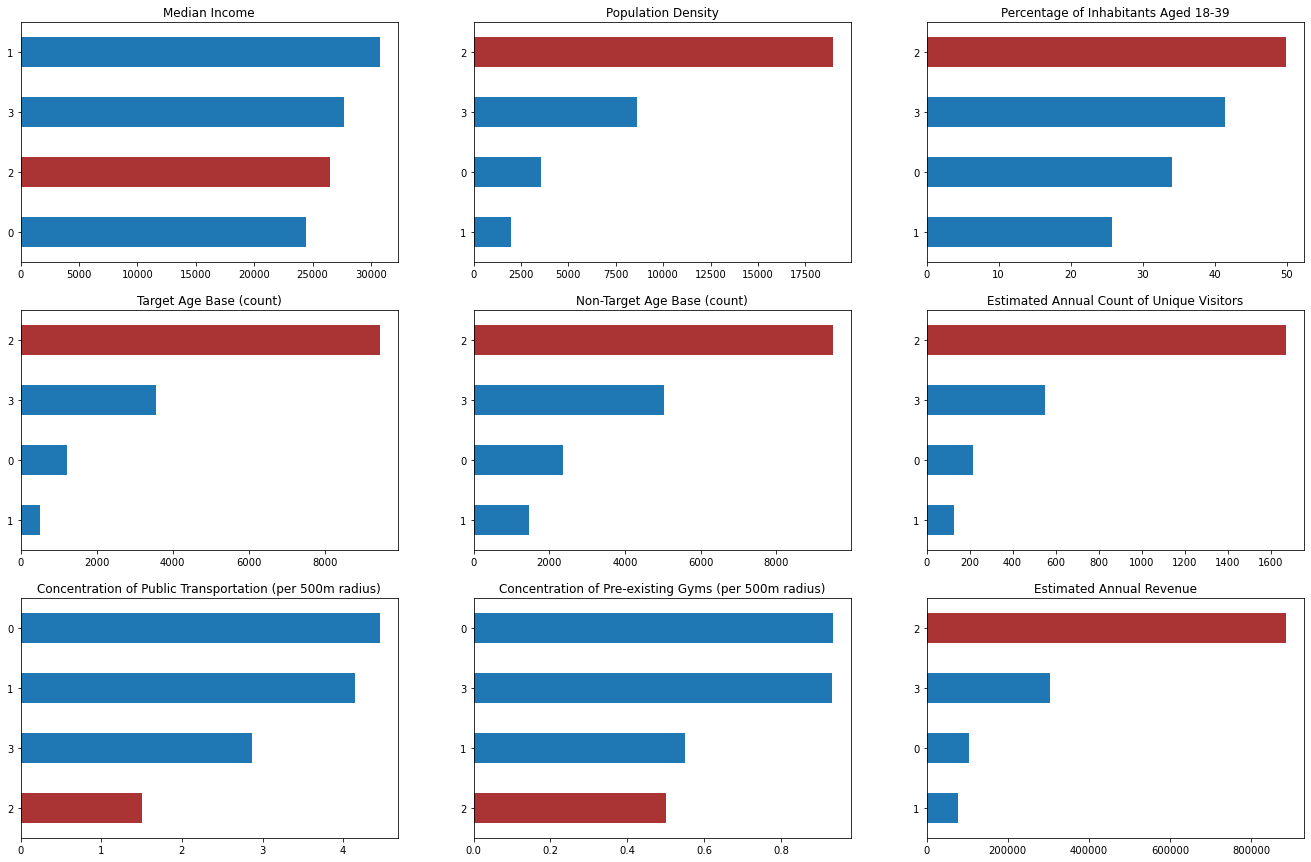

In [140]:
def draw_barchart(dataframe, highlight_index):
    fig = plt.figure(figsize=(23, 15))
    n_rows = n_cols = math.ceil(math.sqrt(dataframe.columns.size))
    for i, col in enumerate(dataframe.columns):
        df = dataframe[[col]].sort_values(by=col)
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        df.plot.barh(ax=ax)
        pos = df.index.get_loc(highlight_index)
        ax.patches[pos].set_facecolor('#aa3333')
        ax.set_title(col)
        ax.get_legend().remove()
    # fig.tight_layout()
    plt.show()

draw_barchart(cluster_results_vis[['Median Income', 'Population Density', 'Percentage of Inhabitants Aged 18-39',
                               'Target Age Base (count)','Non-Target Age Base (count)', 'Estimated Annual Count of Unique Visitors',
                               'Concentration of Public Transportation (per 500m radius)','Concentration of Pre-existing Gyms (per 500m radius)',
                               'Estimated Annual Revenue']], 2)

### 4. Discussion
According to the results, neighborhood cluster 2 was deemed optimal because it yielded the highest estimated annual revenue.

Cluster 2, however, did not have the optimal values on ALL of the key feature variables. As shown in the bar charts above, Cluster 2 had the following cons:

* It ranked 3rd (out of 4) in median income
* It had the lowest concentration of public trasnportation stations (i.e, harder to reach)

These cons were nonetheless offset by the following pros:

* It had the lowest concentration of pre-existing gyms (i.e., less competition)
* It had the highest population density
* It had the highest proportion of inhabitants aged 18-39

In the following sections, I inspect the indivdiual neighborhoods within the optimal cluster, and then discuss several limitations and future directions.

### 4.1 Inspecting the Neighborhoods Within the Optimal Cluster
#### Checking Which Neighborhoods are in Cluster 2

In [141]:
C2_neighborhoods = df2[df2['Cluster Labels'] == 2]
C2_neighborhoods

,Cluster Labels,Neighborhood,Income_median,Density,Percent_18_39,Latitude,Longitude,Venue_gym,asema
1,2,Punavuori - Bulevardi (Helsinki),29684,17430,38.761086,60.162903,24.942100,0,1
33,2,Sörnäinen - Harju (Helsinki),23319,20476,60.973577,60.186781,24.961958,1,2


### Estmating Annual Revenues in Punavuori and Sörnäinen


In [142]:
# Creating a copy of the dataframe
C2_revenue = C2_neighborhoods.copy()

# Applying the "revenue" function
revenue(C2_revenue)

# Dropping unnecessary columns
C2_revenue.drop(['Cluster Labels', "Latitude", "Longitude"], axis=1, inplace=True)

# Show table
C2_revenue

,Neighborhood,Target age base,Non-target age base,Target age visitors (baseline),Non-target age visitors (baseline),Target age visitors (adjusted),Non-target age visitors (adjusted),Total visitors,Annual revenue
1,Punavuori - Bulevardi (Helsinki),6756,10674,1351,533,1406,555,1961,1164206
33,Sörnäinen - Harju (Helsinki),12484,7992,2496,399,1346,215,1561,728019


### 4.2 Limitations and Future Directions 

The present analysis represents the "first phase" of what would become a larger examination into the hypothetical client's problem. As such, I acknowledge that there are numerous limitations that should be addressed in subsequent analyses.

* First, I chose to cluster the neighborhood based on a total of 5 features only: median income, percentage of inhabitants aged 18-39, population density, concentration of public transportation stations, and concentration of pre-existing gyms. While this parsimony helped to make data collection and analysis efficient, there are many other factors that could drive a neighborhood's suitability for opening a new gym, such as its safety reputation, presence of “R-kioski” (i.e., a popular convenience store chain that sells coffee), neighborhood development plans, and the quality of nearby restaurants and rival cafés. As such, follow-up analyses should aim to collect and examine such additional features.


* Second, the concentration of pre-existing gyms and public transportation stations in each neighborhood was measured using proxies. Specifically, I counted the number of public transportation stations and gyms within a 500m radius area from each neighborhood's central coordinates, which may not accurately represent the presence of those venues throughout the entire neighborhood. For example, there may be a neighborhood with a high concentration of gyms in its outskirts despite having only a few in its central coordinates.


* Third, I estimated annual revenue in each cluster using a formula based on a set of relatively simple mathematical assumptions using only a few variables. For example, the estimation did not take into account visits from tourists or other patrons outside of the focal neighborhood.Many gyms have daily and weekly plans for temporary customer. For example, in a neighborhood such as Kamppi, which is a popular destination for travelers, gym sales may be affected largely by tourists and tmporary customers. As such, the true revenue for this neighborhood could be substantially higher than what I had estimated.


* Finally, I determined the optimal new location solely based on estimated revenues. As such, I did not take into account the variation in costs (e.g., property cost) of opening a new gym in the different locations. I recommend that follow-up analyses address this limitation by estimating total costs in addition to revenue.

### 4.3 Conclusion

In this notebook, I examined the hypothetical client's question of "What is the optimal new gym location in Helsinki?" Using population-related data and venue-related data gathered from Tilastokeskus and Foursquare, respectively, I segmented the neighborhoods of Helsinki into four clusters based on features such as population density, income, proportion of young people, and concentration of nearby public transportation stations and pre-existing gyms. I then ranked the clusters based on annual revenue (i.e., if the gym were to be opened within that cluster), which was estimated using a set of business and mathematical assumptions. According to the results, the neighborhood cluster consisting of Sörnäinen and Punavuori are the optimal new gym locations. Follow-up examinations should aim to utilize additional data (e.g., cost-related data) using more robust assumptions for greater validity.


